In [1]:
import glob
from skimage.io import imread
from skimage.color import gray2rgb
import pandas as pd, numpy as np
import matplotlib.pyplot as plt


from sklearn import datasets, preprocessing, linear_model, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, plot_model


from mlxtend.plotting import plot_confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
dataset_path = '/content/drive/MyDrive/CSE428_LAB/Project/Group_2.zip'
# dataset_path = '/content/Group_2.zip'

with ZipFile(dataset_path, 'r') as zip:
  zip.extractall()

In [4]:
def convert_to_csv(path_to_dataset):
    image_paths = glob.glob(path_to_dataset + '/*/*/*.JPEG')

    train_imgs = []
    test_imgs = []

    for image_path in image_paths:
        image = imread(image_path)
        if image.shape[-1] != 3:
            image = gray2rgb(image)
        if image_path.split('/')[-3] == 'train':
            train_imgs.append(image.ravel().tolist() + [image_path.split('/')[-2]])
        else:
            test_imgs.append(image.ravel().tolist() + [image_path.split('/')[-2]])

    img_0 = imread(image_paths[0])
    column_names = [f"p_{x}" for x in range(np.prod(img_0.shape))] + ['label']

    train_df = pd.DataFrame(train_imgs, columns=column_names)
    test_df = pd.DataFrame(test_imgs, columns=column_names)

    train_df.to_csv(path_to_dataset+'/train.csv', index=False)
    test_df.to_csv(path_to_dataset+'/test.csv', index=False)

convert_to_csv('/content/Group_2')

In [5]:
train_data = pd.read_csv('/content/Group_2/train.csv')
test_data = pd.read_csv('/content/Group_2/test.csv')

print(train_data.shape)
print(test_data.shape)

(2164, 12289)
(250, 12289)


In [6]:
train_label = train_data['label']
test_label = test_data['label']

train_label.unique()
test_label.unique()

array(['camel', 'pig', 'chimpanzee', 'bighorn', 'butterfly'], dtype=object)

In [7]:
# Number of samples per class in the training set
train_samples_per_class = train_data['label'].value_counts()

# Number of samples per class in the test set
test_samples_per_class = test_data['label'].value_counts()

# Print the results
print("Number of samples per class in the training set:")
print(train_samples_per_class)

print("\nNumber of samples per class in the test set:")
print(test_samples_per_class)

Number of samples per class in the training set:
camel         500
chimpanzee    500
butterfly     500
bighorn       414
pig           250
Name: label, dtype: int64

Number of samples per class in the test set:
camel         50
pig           50
chimpanzee    50
bighorn       50
butterfly     50
Name: label, dtype: int64


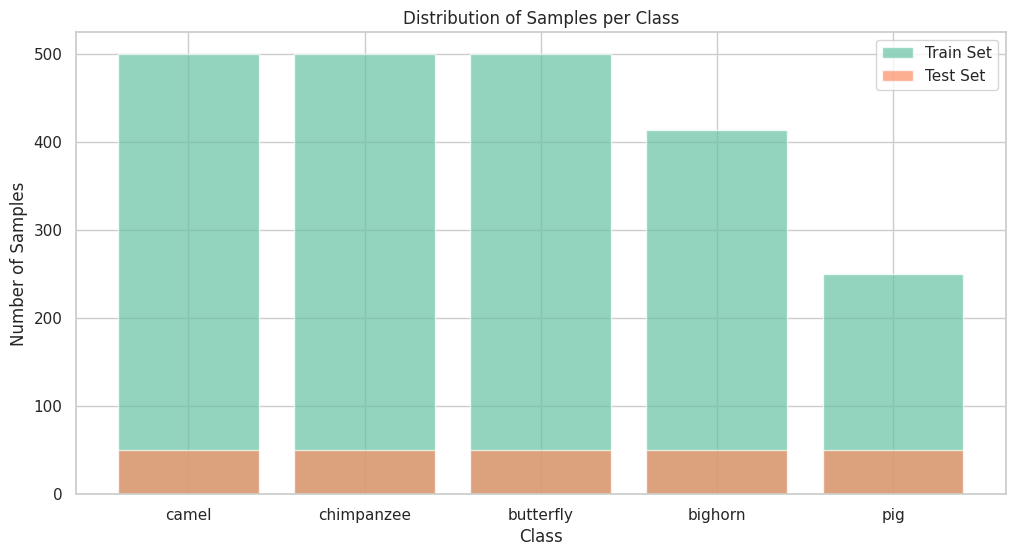

In [8]:
# Show it using a plot. Is the distribution balanced or unbalanced?
import seaborn as sns

# Set a seaborn style
sns.set(style="whitegrid")

# Define pretty colors
colors = sns.color_palette("Set2")

# Plotting the distribution for training set
plt.figure(figsize=(12, 6))
plt.bar(train_samples_per_class.index, train_samples_per_class.values, color=colors[0], alpha=0.7, label='Train Set')

# Plotting the distribution for test set
plt.bar(test_samples_per_class.index, test_samples_per_class.values, color=colors[1], alpha=0.7, label='Test Set')

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Class')
plt.legend()
plt.show()

In [9]:
encode = preprocessing.LabelEncoder()
encode.fit(train_data['label'])
train_data['label'] = encode.transform(train_label)
encode.fit(test_data['label'])
test_data['label'] = encode.transform(test_label)

print(train_data['label'])
print(test_data['label'])

0       2
1       2
2       2
3       2
4       2
       ..
2159    1
2160    1
2161    1
2162    1
2163    1
Name: label, Length: 2164, dtype: int64
0      2
1      2
2      2
3      2
4      2
      ..
245    1
246    1
247    1
248    1
249    1
Name: label, Length: 250, dtype: int64


In [10]:
x_train = train_data.drop(['label'], axis=1)
y_train = train_data['label']

x_test = test_data.drop(['label'], axis=1)
y_test = test_data['label']

In [11]:
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)


# # Reshape training data
# X_train_reshaped = x_train.reshape((-1, 224, 224, 3))

# # Reshape testing data
# X_test_reshaped = x_test.reshape((-1, 224, 224, 3))

# # Confirm the shape changes
# print(X_train_reshaped.shape)
# print(y_train.shape)
# print(X_test_reshaped.shape)
# print(y_test.shape)

## SMOTE application to upsample

In [12]:
number_of_classes = len(encode.classes_)
y_train = to_categorical(y_train, num_classes = number_of_classes)

print("shape of y_train =", y_train.shape)
print("shape of y_test = ", y_test.shape)

shape of y_train = (2164, 5)
shape of y_test =  (250,)


In [13]:
from imblearn.over_sampling import SMOTE

def perform_smote(x_data, y_data):
    y_data_res = np.argmax(y_data, axis = 1)

    print("Number of samples per classes Before applying SMOTE")
    bin_c = np.bincount(y_data_res)
    ii = np.nonzero(bin_c)[0]
    print(np.vstack((ii, bin_c[ii])).T)

    smote_upsample = SMOTE(random_state = 2)
    x_data_res, y_data_res = smote_upsample.fit_resample(x_data, y_data_res.ravel())

    print("Number of samples per classes After applying SMOTE")
    bin_c = np.bincount(y_data_res)
    ii = np.nonzero(bin_c)[0]
    print(np.vstack((ii, bin_c[ii])).T)

    number_of_classes = 5
    y_data_res = to_categorical(y_data_res, num_classes=number_of_classes)

    return x_data_res, y_data_res


X_train_upsample, y_train_upsample = perform_smote(x_train, y_train)

print("Size of train samples after smote")
print(X_train_upsample.shape)
print(y_train_upsample.shape)

Number of samples per classes Before applying SMOTE
[[  0 414]
 [  1 500]
 [  2 500]
 [  3 500]
 [  4 250]]
Number of samples per classes After applying SMOTE
[[  0 500]
 [  1 500]
 [  2 500]
 [  3 500]
 [  4 500]]
Size of train samples after smote
(2500, 12288)
(2500, 5)


In [14]:
x_norm_train_upsample = MinMaxScaler().fit_transform(X_train_upsample)
x_norm_train_upsample = pd.DataFrame(x_norm_train_upsample)
x_norm_train_upsample

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,0.996078,1.000000,0.992157,0.988235,0.996078,0.984314,0.996078,1.000000,0.992157,0.968627,...,0.980392,1.000000,1.000000,0.980392,1.000000,1.000000,0.984314,0.996078,1.000000,0.980392
1,0.325490,0.349020,0.301961,0.372549,0.396078,0.349020,0.380392,0.403922,0.364706,0.384314,...,0.588235,0.603922,0.576471,0.513725,0.662745,0.635294,0.564706,0.521569,0.494118,0.423529
2,0.243137,0.333333,0.262745,0.439216,0.529412,0.450980,0.215686,0.298039,0.223529,0.364706,...,0.870588,0.780392,0.705882,0.713725,0.862745,0.784314,0.792157,0.784314,0.705882,0.713725
3,0.650980,0.713725,0.611765,0.627451,0.690196,0.588235,0.458824,0.533333,0.423529,0.513725,...,0.458824,0.588235,0.560784,0.450980,0.596078,0.568627,0.458824,0.607843,0.580392,0.470588
4,0.690196,0.615686,0.725490,0.686275,0.611765,0.721569,0.686275,0.611765,0.721569,0.686275,...,0.388235,0.674510,0.490196,0.411765,0.701961,0.517647,0.439216,0.670588,0.486275,0.407843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.678431,0.635294,0.505882,0.737255,0.690196,0.568627,0.780392,0.725490,0.631373,0.376471,...,0.439216,0.541176,0.400000,0.286275,0.588235,0.439216,0.333333,0.650980,0.505882,0.396078
2496,0.184314,0.180392,0.180392,0.188235,0.184314,0.184314,0.196078,0.188235,0.184314,0.270588,...,0.109804,0.309804,0.337255,0.141176,0.309804,0.337255,0.137255,0.450980,0.478431,0.278431
2497,0.364706,0.270588,0.184314,0.321569,0.239216,0.145098,0.243137,0.156863,0.082353,0.309804,...,0.082353,0.164706,0.109804,0.090196,0.188235,0.129412,0.109804,0.180392,0.121569,0.101961
2498,0.094118,0.086275,0.078431,0.066667,0.058824,0.050980,0.113725,0.109804,0.113725,0.078431,...,0.847059,0.721569,0.705882,0.713725,0.631373,0.619608,0.631373,0.831373,0.815686,0.839216


In [15]:
x_norm_test = MinMaxScaler().fit_transform(x_test)
x_norm_test = pd.DataFrame(x_norm_test)
x_norm_test

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,0.690196,0.603922,0.745098,0.690196,0.603922,0.745098,0.694118,0.607843,0.749020,0.694118,...,0.094118,0.156863,0.105882,0.082353,0.160784,0.117647,0.101961,0.188235,0.145098,0.129412
1,0.600000,0.627451,0.596078,0.415686,0.443137,0.411765,0.486275,0.517647,0.474510,0.913725,...,0.270588,0.682353,0.572549,0.490196,0.686275,0.576471,0.490196,0.772549,0.662745,0.576471
2,0.235294,0.282353,0.274510,0.235294,0.278431,0.286275,0.305882,0.341176,0.376471,0.458824,...,0.854902,0.913725,0.898039,0.854902,0.913725,0.898039,0.854902,0.917647,0.901961,0.858824
3,0.321569,0.239216,0.164706,0.333333,0.262745,0.184314,0.325490,0.258824,0.196078,0.333333,...,0.792157,0.760784,0.729412,0.588235,0.956863,0.925490,0.784314,1.000000,0.992157,0.850980
4,0.650980,0.631373,0.513725,0.643137,0.623529,0.498039,0.560784,0.541176,0.415686,0.611765,...,0.223529,0.725490,0.756863,0.533333,0.400000,0.427451,0.223529,0.466667,0.494118,0.290196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.058824,0.235294,0.000000,0.396078,0.596078,0.231373,0.290196,0.525490,0.082353,0.223529,...,0.109804,0.231373,0.431373,0.058824,0.345098,0.580392,0.133333,0.282353,0.537255,0.043137
246,0.501961,0.505882,0.482353,0.450980,0.454902,0.431373,0.478431,0.482353,0.458824,0.384314,...,0.278431,0.384314,0.388235,0.317647,0.403922,0.407843,0.345098,0.333333,0.337255,0.274510
247,0.356863,0.117647,0.000000,0.415686,0.176471,0.054902,0.470588,0.223529,0.094118,0.466667,...,0.545098,0.964706,0.294118,0.560784,0.945098,0.282353,0.647059,0.929412,0.274510,0.686275
248,0.137255,0.125490,0.000000,0.168627,0.160784,0.007843,0.109804,0.105882,0.000000,0.090196,...,0.411765,0.541176,0.694118,0.447059,0.431373,0.580392,0.380392,0.082353,0.227451,0.054902


In [16]:
# # Split the data into training and validation sets (80% training, 20% validation)
X_train_upsample, X_val_upsample, y_train_upsample, y_val_upsample = train_test_split(X_train_upsample, y_train_upsample, test_size=0.2, random_state=100)

# Print the shapes of the resulting sets
print("Training set shape:", X_train_upsample.shape, y_train_upsample.shape)
print("Validation set shape:", X_val_upsample.shape, y_val_upsample.shape)

Training set shape: (2000, 12288) (2000, 5)
Validation set shape: (500, 12288) (500, 5)


In [26]:
X_train_upsample = pd.DataFrame(train_data)

# Convert DataFrame to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train_upsample.values, X_train_upsample['label'].values))

# Define the resize function
def resize(image, label):
    return (tf.image.resize(image, (224, 224)), label)

# Apply the resize function to the dataset
X_train_upsample_resize = dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)


ValueError: ignored

In [ ]:
SHUFFLE_VAL = len(X_train_upsample_resize) // 1000   # Divide by big value on free Colab
BATCH_SIZE = 4   # Use small batch size on free Colab

train_dataset = X_train_upsample_resize.shuffle(SHUFFLE_VAL)
train_dataset = train_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
X_train_upsample_reshape = np.arange(24576000).reshape(2000, 12288).reshape((X_train_upsample.shape[0]*3, 224, 224))

# X_train_upsample.values.reshape(X_train_upsample.shape[0], 224, 224, 3)
# X_val_upsample_reshape = X_val_upsample.values.reshape(X_val_upsample.shape[0], 224, 224, 3)
# X_test_upsample_reshape = X_val_upsample.values.reshape(X_val_upsample.shape[0], 224, 224, 3)



print(X_train_upsample_reshape.shape)
# print(test_data_reshape.shape)

ValueError: ignored

In [ ]:
def alexnet_model(input_shape, number_of_classes):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 2
    model.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu')) # padding='same' means zero padding applied to get same spatial dimensions for output
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))

    # Layer 4
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))

    # Layer 5
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten
    model.add(Flatten())

    # Layer 6
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Layer 7
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(1000, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Assuming input shape of (224, 224, 3) for RGB images
input_shape = (224, 224, 3)
model = alexnet_model(input_shape, number_of_classes)

# Print model summary
model.summary()


In [ ]:
def reports(model, X_test, y_test):
  y_test
  y_test_actual = np.argmax(y_test, axis = 1)

  y_test_pred = model.predict(X_test)
  y_test_predicted = np.argmax(y_test_pred, axis = 1)

  ############## Performance metrics ################
  from sklearn import metrics

  print("Performance for Test data:")
  print("Confustion Matrix:")
  print(metrics.confusion_matrix(y_test_actual, y_test_predicted))

  print("Classification metrics:")
  print(metrics.classification_report(y_test_actual, y_test_predicted, digits = 3, target_names = encode.classes_))




In [ ]:
model.fit(X_train_upsample, y_train_upsample, epochs=50, verbose=1, validation_data=(X_val_upsample, y_val_upsample))

In [ ]:
model.fit(X_train_upsample, y_train_upsample, epochs=5, batch_size=32, validation_split=0.2)